In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [213]:
w_q = 6e9;
lambda_ = 0.1 * w_q
theta = np.pi/6
N = 5   # Vector space of photon

w_cq = np.linspace(0.8, 2.2, 5000)
w_c = w_cq * w_q

# Photon
a = tensor(identity(2), identity(2), destroy(N))
adag = a.dag()
X = a + adag

# Atom 1
sx1 = tensor(sigmax(), identity(2), identity(N))
sz1 = tensor(sigmaz(), identity(2), identity(N))

# Atom 2
sx2 = tensor(identity(2), sigmax(), identity(N))
sz2 = tensor(identity(2), sigmaz(), identity(N))

H_q = -(w_q/2) * (sz1 + sz2)   # Qubit Hamitonian
idx = 0
evals_mat = np.zeros((len(w_cq),2*2*N))

for wc in w_c:
    H_c = wc * adag * a       # Cavity Hamiltonian
    V = lambda_ * X * (np.cos(theta) * (sx1 + sx2) + np.sin(theta) * (sz1 + sz2))
    H_K = 8e7 * adag * adag * a * a
    H_0 = H_q + H_c + V + H_K
    evals, ekets = H_0.eigenstates()
    evals_mat[idx, :] = evals
    idx += 1

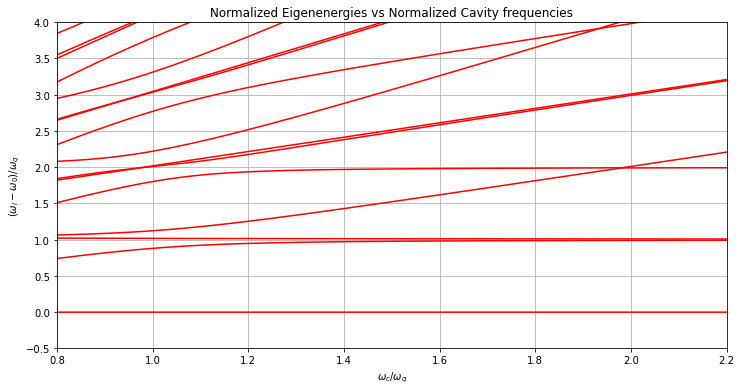

In [214]:
fig, ax = plt.subplots(figsize=(12,6))

for n in range(2*2*N):
    
    # A plot of normalized eigenenergy differences vs the normalized cavity frequencies
    
    ax.plot(w_cq, (evals_mat[:,n] - evals_mat[:,0])/w_q, 'r')
    
ax.set_xlim(0.8,2.2)
ax.set_ylim(-0.5,4)
ax.set_xlabel('$\omega_c/\omega_q$')
ax.set_ylabel('$(\omega_i - \omega_0)/\omega_q$')
ax.set_title('Normalized Eigenenergies vs Normalized Cavity frequencies')
ax.grid()

In [215]:
np.argmin(evals_mat[:,4] - evals_mat[:,3])

4212

In [216]:
w_c_min_idx = np.argmin(evals_mat[:,4] - evals_mat[:, 3])
w_c_min = w_c[w_c_min_idx]      # Cavity frequency set at this minimum splitting
w_30 = evals_mat[w_c_min_idx, 3] - evals_mat[w_c_min_idx, 0]   # Eigenenergy of |3> at min. splitting
w_40 = evals_mat[w_c_min_idx, 4] - evals_mat[w_c_min_idx, 0]   # Eigenenergy of |4> at min. splitting 
w_43 = w_40 - w_30          # Energy difference b/w |3> and |4> at min. splitting
w_d = (w_40 + w_30)/2       # Drive frequency
tau = 0.25/w_43

In [217]:
def drive(t, args):
    return 4.12 * np.exp(-t*t / (2 * tau * tau)) / (tau * np.sqrt(2 * np.pi)) * np.cos(w_d * t)

In [218]:
# Hamiltonian

H_c_min = w_c_min * adag * a       # Cavity Hamiltonian
H_min = H_q + H_c_min + H_K + V
evals, ekets = H_min.eigenstates()

H = [H_min, [X, drive]]

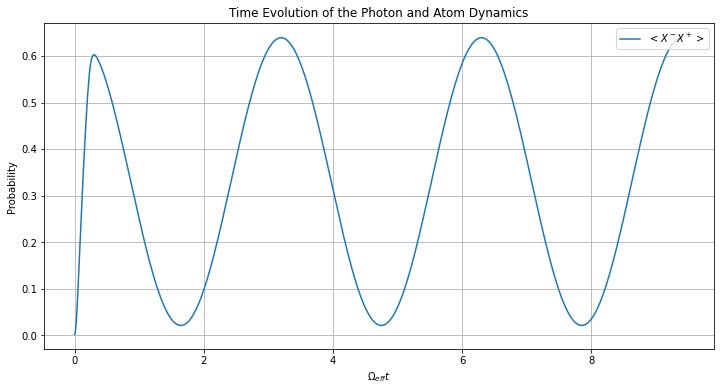

In [219]:
X_dest = 0
C1_dest = 0
C2_dest = 0

sm1 = tensor(destroy(2), qeye(2), qeye(N))
sp1 = tensor(create(2), qeye(2), qeye(N))

sm2 = tensor(qeye(2), destroy(2), qeye(N))
sp2 = tensor(qeye(2), create(2), qeye(N))

for j in range(12):
    for k in range(3, 5):
        if k > j:
            X_jk =  ekets[j].dag() * (a + adag) * ekets[k]
            X_dest += X_jk * ekets[j] * ekets[k].dag()
                        
for j in range(len(ekets)):
    for k in range(len(ekets)):
        if k > j:
            C1_jk = ekets[j].dag() * (sm1 + sp1) * ekets[k]
            C2_jk = ekets[j].dag() * (sm2 + sp2) * ekets[k]
            C1_dest += C1_jk * ekets[j] * ekets[k].dag()
            C2_dest += C2_jk * ekets[j] * ekets[k].dag()

Omega_eff = (8/3) * np.sin(theta) * np.cos(theta)**2 * w_q * 0.001
t = np.linspace(0, 3 * np.pi/Omega_eff, 5000)

psi0 = tensor(basis(2,0), basis(2,0), fock(N,0))
options = Options(nsteps = 100000)
X_sol = mesolve(H, psi0, t, [], e_ops = [X_dest.dag() * X_dest], options = options)

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(Omega_eff * t, X_sol.expect[0], label = '$<X^-X^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics')
ax.grid()

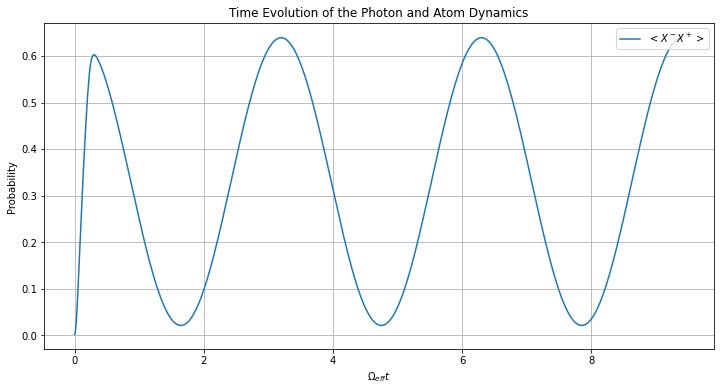

In [231]:
X_dest = 0
C1_dest = 0
C2_dest = 0

sm1 = tensor(destroy(2), qeye(2), qeye(N))
sp1 = tensor(create(2), qeye(2), qeye(N))

sm2 = tensor(qeye(2), destroy(2), qeye(N))
sp2 = tensor(qeye(2), create(2), qeye(N))

for j in range(12):
    for k in range(3, 5):
        if k > j:
            X_jk =  ekets[j].dag() * (a + adag) * ekets[k]
            X_dest += X_jk * ekets[j] * ekets[k].dag()
                        
for j in range(len(ekets)):
    for k in range(len(ekets)):
        if k > j:
            C1_jk = ekets[j].dag() * (sm1 + sp1) * ekets[k]
            C2_jk = ekets[j].dag() * (sm2 + sp2) * ekets[k]
            C1_dest += C1_jk * ekets[j] * ekets[k].dag()
            C2_dest += C2_jk * ekets[j] * ekets[k].dag()

Omega_eff = (8/3) * np.sin(theta) * np.cos(theta)**2 * w_q * 0.001
t = np.linspace(0, 3 * np.pi/Omega_eff, 5000)

psi0 = tensor(basis(2,0), basis(2,0), fock(N,0))
options = Options(nsteps = 100000)
X_sol = mesolve(H, psi0, t, [], e_ops = [X_dest.dag() * X_dest], options = options)

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(Omega_eff * t, X_sol.expect[0], label = '$<X^-X^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics')
ax.grid()

In [220]:
np.max(X_sol.expect[0])

0.6393554337978175

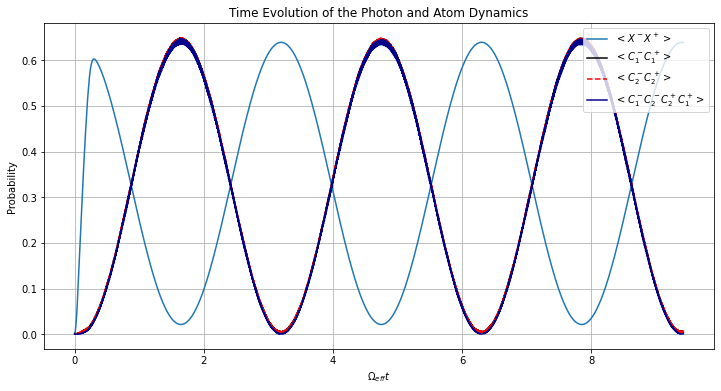

In [221]:
C1 = mesolve(H, psi0, t, [], e_ops = [C1_dest.dag() * C1_dest], options = options)
C2 = mesolve(H, psi0, t, [], e_ops = [C2_dest.dag() * C2_dest], options = options)
G = mesolve(H, psi0, t, [], e_ops = [C1_dest.dag() * C2_dest.dag() * C2_dest * C1_dest], options = options)

fig, ax = plt.subplots(figsize=(12,6))
#Omega = w_43/2

ax.plot(Omega_eff * t, X_sol.expect[0], label = '$<X^-X^+>$')
ax.plot(Omega_eff * t, C1.expect[0], 'black', label = '$<C_1^-C_1^+>$')
ax.plot(Omega_eff * t, C2.expect[0], 'r--', label = '$<C_2^-C_2^+>$')
ax.plot(Omega_eff * t, G.expect[0], 'darkblue', label = '$<C_1^-C_2^-C_2^+C_1^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics')
ax.grid()

In [222]:
np.max(C2.expect[0])

0.6494056593803148

In [223]:
np.max(C1.expect[0])

0.6494056593803149

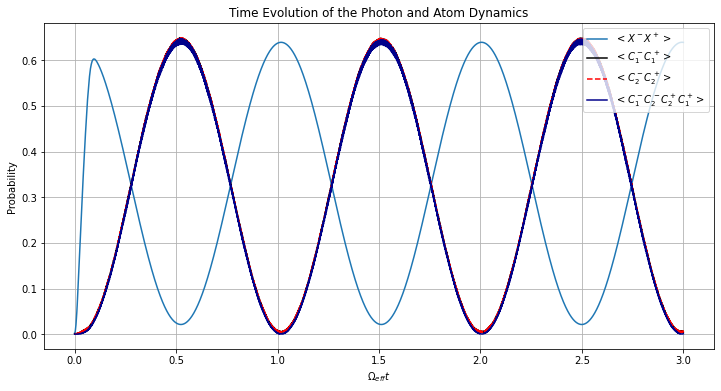

In [224]:
fig, ax = plt.subplots(figsize=(12,6))
#Omega = w_43/2

ax.plot(Omega_eff * t / np.pi, X_sol.expect[0], label = '$<X^-X^+>$')
ax.plot(Omega_eff * t / np.pi, C1.expect[0], 'black', label = '$<C_1^-C_1^+>$')
ax.plot(Omega_eff * t / np.pi, C2.expect[0], 'r--', label = '$<C_2^-C_2^+>$')
ax.plot(Omega_eff * t / np.pi, G.expect[0], 'darkblue', label = '$<C_1^-C_2^-C_2^+C_1^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics')
ax.grid()

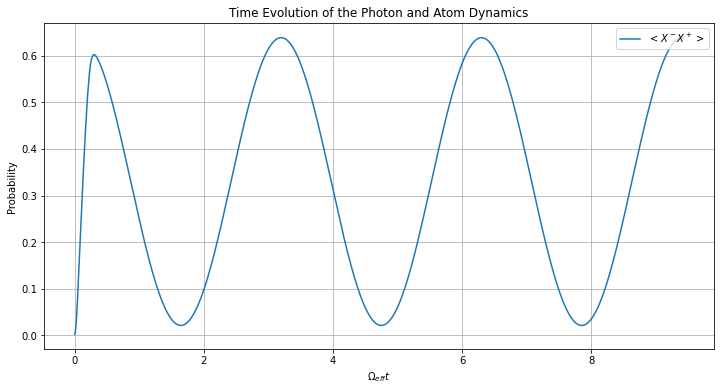

In [225]:
flux = mesolve(H, psi0, t, c_ops=[X_dest.dag()*X_dest], e_ops=[X_dest.dag()*X_dest], options=options)
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(Omega_eff * t, flux.expect[0], label = '$<X^-X^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics')
ax.grid()

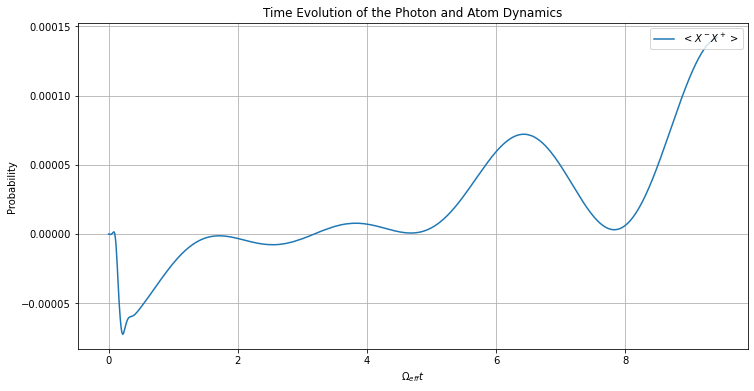

In [226]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(Omega_eff * t, X_sol.expect[0] - flux.expect[0], label = '$<X^-X^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics')
ax.grid()